## **View Webknossos data and segmentations in 3D with Napari**
---
Visualize results from U-net predictions by Wilco van Nes

In [1]:
# Data import
import webknossos as wk
import numpy as np
import zarr

# Napari
import napari

# Analysis
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Create an empty viewer
viewer = napari.Viewer()

In [2]:
def import_wk_dataset_remote(TOKEN, url, dataset_name, organization_id,
                             MAG, segmentation, layer="color", bbox=None) -> None:
    # use the context to get acces to your group
    with wk.webknossos_context(
        token=TOKEN,
        url=url
    ):

    # open remote dataset with dataset name, organization id and WebKnossos url 
        dataset = wk.Dataset.open_remote(
                dataset_name_or_url = dataset_name,
                organization_id = organization_id,
                webknossos_url = url)
        voxel_size = dataset.voxel_size

        EM = dataset.get_layer(layer) # EM data Layer
        labels = dataset.get_layer(segmentation) # Segmentation layer
        
        mag_view = EM.get_mag(MAG) # MagView
        mag_view_seg = labels.get_mag(MAG) # MagView

        # Get data at required resolution
        view = mag_view.get_view(absolute_offset=bbox.topleft, size=bbox.size) # "absolute_offset" and "size" are in Mag(1)!
        view_seg = mag_view_seg.get_view(absolute_offset=bbox.topleft, size=bbox.size) # "absolute_offset" and "size" are in Mag(1)!

        # Read data from remote
        data = view.read()
        seg = view_seg.read()

        # return data, voxel size
        return dataset, data, seg, voxel_size

### **3.1 Configure dataset parameters**
---

In [6]:
TOKEN = "2kpxMaHbL3vhcH7K" # Don't share with others!
url = "https://webknossos.tnw.tudelft.nl"
dataset_name = "20230105_NK_01_with_predictions"
organization_id = "hoogenboom-group"
dir_path = 'Z:/webknossos/binaryData/hoogenboom-group/20230105_NK_01_with_predictions'
layer="WT" # "WT" or "KO"
segmentation="mito-segmentation-MitoNet"

mag_x, mag_y, mag_z = 4, 4, 1 # Zoom level of data (x, y, z). (1, 1, 1) is full resolution
MAG = wk.Mag(f"{mag_x}-{mag_y}-{mag_z}")

In [7]:
# Define bounding box here
bbox = wk.BoundingBox((8434, 6912, 0),
                      (4096, 4096, 37)).align_with_mag(MAG) # ((x0, y0, z0), (x_size, y_size, z_size))

### **3.2 Read data from WebKnossos (remote or local)**
---
Reads data test stack from remote `WebKnossos` dataset

In [8]:
# For remote access to data (can be a bit slow to load...)
dataset, data, seg, voxelsize = import_wk_dataset_remote(TOKEN, 
                                                         url, 
                                                         dataset_name, 
                                                         organization_id, 
                                                         MAG=MAG, 
                                                         segmentation=segmentation, 
                                                         layer=layer, 
                                                         bbox=bbox)
scale_factor = voxelsize[2] / voxelsize[0] / (mag_x / mag_z) # determine scalefactor for viewing
data, seg = np.squeeze(data), np.squeeze(seg)
print(f"Data successfully loaded. Data has shape {data.shape} (in x, y, z)") # Coordinates are (x, y, z), but Napari weirdly reads this as (y, z, x)...

Data successfully loaded. Data has shape (1023, 1024, 37) (in x, y, z)


### 3.2 Add data + segmentations to `Napari` viewer
---
Reads data and segmentations from WebKnossos into `Napari`

In [9]:
# Add data to viewer
viewer.add_image(np.transpose(data, (2, 0, 1)),
                              scale=(scale_factor, 1, 1)) # Use scalefactor for realistic rendering

# Add segmentation
labels_layer = viewer.add_labels(np.transpose(seg, (2, 0, 1)), 
                                 name='segmentation', 
                                 scale=(scale_factor, 1, 1))                    

In [17]:
# This is for the 3D inference (3D instance segmentation)
# Analyze the different objects and their size
label_layer = viewer.layers['segmentation']
mito_labels = np.squeeze(label_layer.data)
volumes = np.transpose(np.unique(mito_labels, 
                    return_counts=True))
mito_volumes = pd.DataFrame(data=volumes[1:], columns=['label','volume (voxels)']) # Ignore background label which is 0
mito_volumes.head()

,label,volume (voxels)
0,5,459
1,7,4573
2,15,1603
3,24,416
4,25,317


<Axes: >

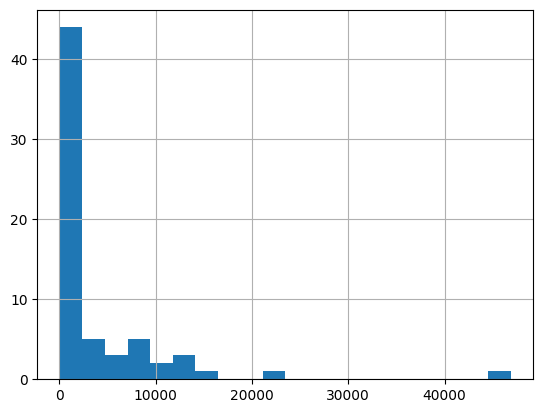

In [18]:
# Plot histogram of organelle volumes
mito_volumes['volume (voxels)'].hist(bins=20)

### **3.3 Save data + segmentations to disk**
---
Saves `Napari` data and segmentation layers to disk

In [49]:
## Segmentation
viewer.layers['segmentation'].save('seg.tiff')

['seg.tiff']

In [51]:
## Data
viewer.layers['Image'].save('cells.tiff')

['cells.tiff']